In [ ]:
! pip uninstall torchaudio torchvision --y
! pip uninstall torch --y
! pip install torch==2.4
! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
! pip install torch-geometric
! pip install scikit-learn
! pip install matplotlib


Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch/_compile.py:31: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


Epoch :01
Training Loss: 2.1002
Validation Loss: 2.0086
Validation AP: 0.6939, Validation AUC: 0.7032, Validation MRR: 0.8393
Test AP: 0.6931, Test AUC: 0.7085, Test MRR: 0.8451
Epoch 1 completed in 19.14s
Epoch :02
Training Loss: 1.9467
Validation Loss: 1.8961
Validation AP: 0.7718, Validation AUC: 0.7932, Validation MRR: 0.8836
Test AP: 0.7737, Test AUC: 0.7963, Test MRR: 0.8886
Epoch 2 completed in 20.25s
Epoch :03
Training Loss: 1.7894
Validation Loss: 1.7192
Validation AP: 0.8362, Validation AUC: 0.8626, Validation MRR: 0.9216
Test AP: 0.8197, Test AUC: 0.8460, Test MRR: 0.9199
Epoch 3 completed in 20.37s
Epoch :04
Training Loss: 1.7086
Validation Loss: 1.7233
Validation AP: 0.8414, Validation AUC: 0.8688, Validation MRR: 0.9284
Test AP: 0.8319, Test AUC: 0.8592, Test MRR: 0.9248
Epoch 4 completed in 20.38s
Epoch :05
Training Loss: 1.6641
Validation Loss: 1.6796
Validation AP: 0.8477, Validation AUC: 0.8707, Validation MRR: 0.9287
Test AP: 0.8386, Test AUC: 0.8629, Test MRR: 0.927

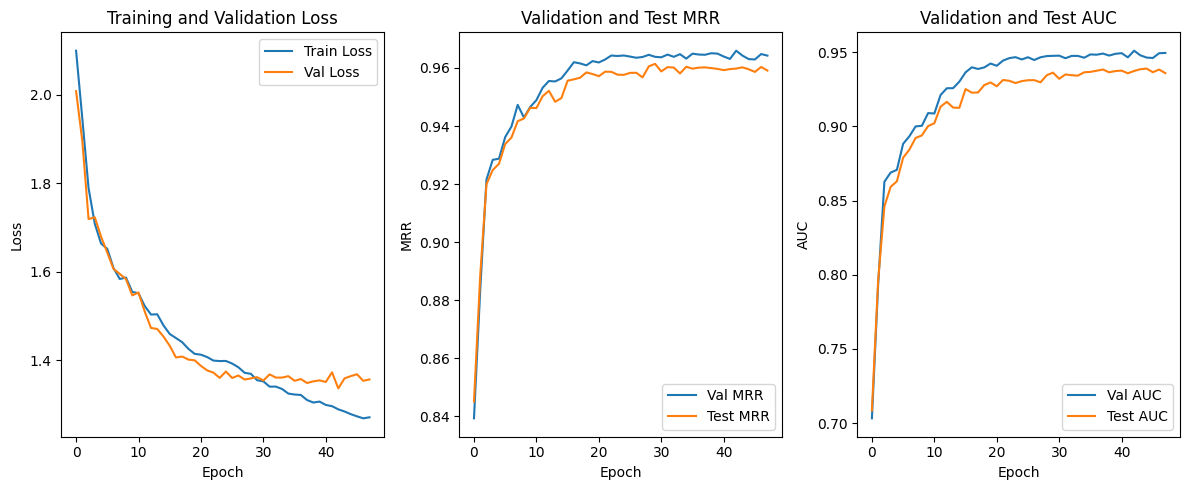

In [ ]:
# parallel graph pooling with fusion layer
import torch

import os.path as osp
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv, GCNConv
from torch_geometric.nn.dense import dense_diff_pool
from torch_geometric.utils import to_dense_adj, to_dense_batch
from torch_geometric.nn.models.tgn import IdentityMessage, LastAggregator, LastNeighborLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path and dataset setup
path = osp.join('/content/', 'data', 'JODIE')
dataset = JODIEDataset(path, name='wikipedia')
data = dataset[0].to(device)

# Split dataset into train/val/test
train_data, val_data, test_data = data.train_val_test_split(val_ratio=0.15, test_ratio=0.15)

# Initialize data loaders
train_loader = TemporalDataLoader(train_data, batch_size=200, neg_sampling_ratio=1.0)
val_loader = TemporalDataLoader(val_data, batch_size=200, neg_sampling_ratio=1.0)
test_loader = TemporalDataLoader(test_data, batch_size=200, neg_sampling_ratio=1.0)

# Initialize neighbor loader
neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)



# Utility function for optional debugging output
def debug_shapes(**shapes):
    for name, value in shapes.items():
        print(f"{name} shape: {value.shape}")


class DiffPoolLayer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_nodes, ratio=0.25):
        super().__init__()
        self.num_clusters = max(1, int(ratio * num_nodes))
        self.gnn_embed = GCNConv(in_channels, hidden_channels)
        self.gnn_pool = GCNConv(in_channels, self.num_clusters)

    def forward(self, x, edge_index, batch, debug=False):
        embed = self.gnn_embed(x, edge_index)
        s = self.gnn_pool(x, edge_index).softmax(dim=-1)

        # Convert to dense batch
        x, mask = to_dense_batch(embed, batch)
        adj = to_dense_adj(edge_index, batch)
        s, _ = to_dense_batch(s, batch)

        if debug:
            debug_shapes(x=x, adj=adj, s=s)

        # Differential pooling
        x, adj, link_loss, ent_loss = dense_diff_pool(x, adj, s, mask, normalize=True)
        x = x.view(-1, x.size(-1))  # Flatten the output if necessary

        return x, adj, link_loss, ent_loss


class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2, dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)


class FeatureFusion(torch.nn.Module):
    def __init__(self, tgn_dim, diffpool_dim, output_dim):
        super().__init__()
        self.tgn_projection = Linear(tgn_dim, output_dim)
        self.diffpool_projection = Linear(diffpool_dim, output_dim)
        self.attention = torch.nn.MultiheadAttention(embed_dim=output_dim, num_heads=4, batch_first=True)
        self.final_projection = Linear(output_dim, output_dim)

    def forward(self, tgn_features, diffpool_features):
        tgn_proj = self.tgn_projection(tgn_features)
        diffpool_proj = self.diffpool_projection(diffpool_features)
        diffpool_proj = F.interpolate(diffpool_proj.unsqueeze(0).unsqueeze(0),
                                      size=(tgn_proj.size(0), diffpool_proj.size(1)),
                                      mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        combined = tgn_proj + diffpool_proj
        attended, _ = self.attention(combined.unsqueeze(0), combined.unsqueeze(0), combined.unsqueeze(0))
        return self.final_projection(attended.squeeze(0))


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = (self.lin_src(z_src) * self.lin_dst(z_dst)).relu()
        return self.lin_final(h)


# Model dimensions
memory_dim = time_dim = embedding_dim = 100
hidden_dim = 64
final_dim = 128

# Initialize models
memory = TGNMemory(data.num_nodes, data.msg.size(-1), memory_dim, time_dim,
                   message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
                   aggregator_module=LastAggregator()).to(device)
gnn = GraphAttentionEmbedding(memory_dim, embedding_dim, data.msg.size(-1), memory.time_enc).to(device)
diffpool = DiffPoolLayer(memory_dim, hidden_dim, data.num_nodes).to(device)
fusion = FeatureFusion(embedding_dim, hidden_dim, final_dim).to(device)
link_pred = LinkPredictor(final_dim).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(list(memory.parameters()) + list(gnn.parameters()) + list(diffpool.parameters()) +
                             list(fusion.parameters()) + list(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

# Helper vector for node mapping
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


def process_batch(batch, debug=False):
    n_id, edge_index, e_id = neighbor_loader(batch.n_id)

    # debug_shapes(n_id=n_id, edge_index=edge_index, e_id=e_id)


    assoc[n_id] = torch.arange(n_id.size(0), device=device)
    batch_vector = torch.zeros(n_id.size(0), dtype=torch.long, device=device)

    # TGN embedding
    z, last_update = memory(n_id)
    z_tgn = gnn(z, last_update, edge_index, data.t[e_id].to(device), data.msg[e_id].to(device))

    # DiffPool embedding
    z_diffpool, adj_diffpool, link_loss, ent_loss = diffpool(z, edge_index, batch_vector, debug=debug)

    # Fuse features
    z_combined = fusion(z_tgn, z_diffpool)
    return z_combined, link_loss, ent_loss


def train_epoch():
    memory.train(), gnn.train(), diffpool.train(), fusion.train(), link_pred.train()
    memory.reset_state(), neighbor_loader.reset_state()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        z_combined, link_loss, ent_loss = process_batch(batch, debug=False)
        pos_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.dst]])
        neg_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.neg_dst]])

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))
        loss += 0.1 * (link_loss + ent_loss)

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events

def calculate_mrr(pos_score, neg_score):
    """
    Calculate Mean Reciprocal Rank (MRR) for a batch of queries.
    Args:
        pos_score: Tensor of shape [batch_size, 1], scores for positive examples.
        neg_score: Tensor of shape [batch_size, num_negatives], scores for negative examples.
    Returns:
        MRR score (float)
    """
    # Validate input shapes
    if pos_score.size(0) != neg_score.size(0):
        raise ValueError("pos_score and neg_score must have the same batch size.")

    # Combine positive and negative scores for ranking
    scores = torch.cat([pos_score, neg_score], dim=1)  # Shape: [batch_size, 1 + num_negatives]

    # Create binary labels (1 for positive, 0 for negatives)
    labels = torch.zeros_like(scores)
    labels[:, 0] = 1  # First column contains positive scores

    # Sort scores in descending order and get indices
    _, indices = scores.sort(dim=1, descending=True)

    # Get ranks of positive samples
    positive_indices = indices == 0  # Locate positive samples in sorted indices
    ranks = (positive_indices.nonzero(as_tuple=False)[:, 1] + 1).float()  # 1-based rank

    # Calculate MRR
    mrr = (1.0 / ranks).mean()

    return mrr.item()



@torch.no_grad()
def evaluate(loader):
    memory.eval(), gnn.eval(), diffpool.eval(), fusion.eval(), link_pred.eval()
    torch.manual_seed(12345)

    aps, aucs, mrrs = [], [], []
    total_loss = 0
    total_events = 0

    with torch.no_grad():  # Add this to prevent gradient computation during evaluation
        for batch in loader:
            batch = batch.to(device)

            z_combined, link_loss, ent_loss = process_batch(batch, debug=False)
            pos_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.dst]])
            neg_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.neg_dst]])

            # Calculate loss the same way as in training
            loss = criterion(pos_out, torch.ones_like(pos_out))
            loss += criterion(neg_out, torch.zeros_like(neg_out))
            loss += 0.1 * (link_loss + ent_loss)

            # Accumulate loss weighted by batch events
            total_loss += float(loss) * batch.num_events
            total_events += batch.num_events

            # Calculate MRR
            mrr = calculate_mrr(pos_out, neg_out)
            mrrs.append(mrr)

            # Other metrics
            y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
            y_true = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))], dim=0)
            aps.append(average_precision_score(y_true, y_pred))
            aucs.append(roc_auc_score(y_true, y_pred))

            memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
            neighbor_loader.insert(batch.src, batch.dst)

    avg_loss = total_loss / total_events
    return (avg_loss,
            float(torch.tensor(aps).mean()),
            float(torch.tensor(aucs).mean()),
            float(torch.tensor(mrrs).mean()))


# Training loop with early stopping
import time
import matplotlib.pyplot as plt

train_losses, val_losses, val_aucs, test_aucs, val_mrrs, test_mrrs = [], [], [], [], [], []
# best_val_auc = 0
early_stopping_patience = 5
patience_counter = 0
best_val_ap = 0

# Checkpoint and early stopping fix
for epoch in range(1, 151):
    start_time = time.time()
    train_loss = train_epoch()
    # val_ap, val_auc, val_mrr = evaluate(val_loader)
    # test_ap, test_auc, test_mrr = evaluate(test_loader)

    # # Track metrics
    # train_losses.append(train_loss)
    # val_losses.append(val_auc)
    # val_aucs.append(val_auc)
    # test_aucs.append(test_auc)
    # val_mrrs.append(val_mrr)  # Append validation MRR
    # test_mrrs.append(test_mrr)  # Append test MRR

    val_loss, val_ap, val_auc, val_mrr = evaluate(val_loader)
    test_loss, test_ap, test_auc, test_mrr = evaluate(test_loader)

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)  # Now tracking actual validation loss
    val_aucs.append(val_auc)
    test_aucs.append(test_auc)
    val_mrrs.append(val_mrr)
    test_mrrs.append(test_mrr)

    #print(f'Epoch {epoch:02d}, Loss: {train_loss:.4f}, Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}, Val MRR: {val_mrr:.4f}, Test AUC: {test_auc:.4f}, Test MRR: {test_mrr:.4f}')
    print(f"Epoch :{epoch:02d}")
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f"Validation AP: {val_ap:.4f}, Validation AUC: {val_auc:.4f}, Validation MRR: {val_mrr:.4f}")
    print(f"Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}, Test MRR: {test_mrr:.4f}")
    print("================")

    current_val_ap = val_ap


    # Check for early stopping
    if current_val_ap > best_val_ap:
        best_val_ap = current_val_ap
        patience_counter = 0  # Reset patience counter
        if epoch % 10 == 0:
            # Save each component's state dictionary
            torch.save({
            'memory': memory.state_dict(),
            'gnn': gnn.state_dict(),
            'diffpool': diffpool.state_dict(),
            'fusion': fusion.state_dict(),
            'link_pred': link_pred.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'val_auc': val_auc,
            'val_ap': val_ap,
            'val_mrr': val_mrr,
            'test_auc': test_auc,
            'test_ap': test_ap,
            'test_mrr': test_mrr,
        }, f"model_checkpoint_epoch_{epoch}.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f}s")


# Plotting Loss and AUC over Epochs
plt.figure(figsize=(12, 5))

# Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig("train_val_loss1.png")  # Save loss plot

# Plot MRR
plt.subplot(1, 3, 2)
plt.plot(val_mrrs, label='Val MRR')
plt.plot(test_mrrs, label='Test MRR')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.legend()
plt.title('Validation and Test MRR')

# Validation and Test AUC
plt.subplot(1, 3, 3)
plt.plot(val_aucs, label='Val AUC')
plt.plot(test_aucs, label='Test AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation and Test AUC')
plt.savefig("val_test_auc1.png")  # Save AUC plot

plt.tight_layout()
plt.show()
